# Trainer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [2]:
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

## Data

In [3]:
CSV_FILE_PATH = "../data/preprocessed_data.csv"
MAX_RSSI = 0
MIN_RSSI = -99
NUM_RSSI_UNIT = MAX_RSSI - MIN_RSSI + 1
DENOISE_SNR = 20

df = pd.read_csv(CSV_FILE_PATH)

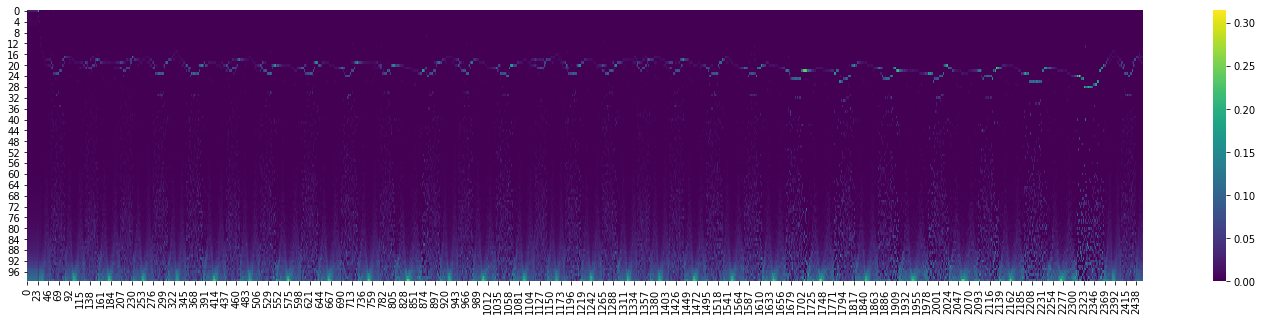

In [4]:
def prep_data(df, tag):
    # extra training raws
    df_tx = df[df.tag == tag][1:].reset_index(drop=True)
    # remove unused columns
    raw_df = df_tx.drop(columns=['tag', 'timestamp'])
    # split input and label columns
    input_df = raw_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].astype('float')
    label_df = rCSV_FILE_PATH = "../data/preprocessed_data.csv"
MAX_RSSI = 0
MIN_RSSI = -99
NUM_RSSI_UNIT = MAX_RSSI - MIN_RSSI + 1
DENOISE_SNR = 20

df = pd.read_csv(CSV_FILE_PATH)aw_df[['x','y','z']]
    # convert input to pdf
    input_df = input_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].div(input_df.sum(axis=1), axis=0)
    
    plt.figure(figsize=(25,5))
    ax = sns.heatmap(input_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].to_numpy().transpose(1,0),cmap="viridis")
    plt.show()
    
    # concat label with input as new df
    new_df = pd.concat([label_df, input_df], axis=1)
    # get the diff of each rows
    # diff_df = new_df.diff(axis=0)[1:]
    # normalize
    norm_df = (new_df-new_df.mean())/(new_df.std() + 1e-10)

    return norm_df, new_df
norm_df, new_df = prep_data(df, 'BP_WirelessTransmitter_C_1')

## Visualize in 3D

In [5]:
# pdf_np = norm_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].to_numpy()
# MAX_X, MAX_Y = pdf_np.shape
# MAX_X, MAX_Y
# MAX_X = 200
# x = np.linspace(0, MAX_X-1, MAX_X).astype('int64')
# y = np.linspace(0, MAX_Y-1, MAX_Y).astype('int64')
# X, Y = np.meshgrid(x, y)
# Z = pdf_np[x].transpose(1,0)
# X.shape, Y.shape, x.shape, y.shape, Z.shape

# plt.figure(figsize = (10,10))
# ax = plt.axes(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
# ax.set_box_aspect(aspect = (5,1,0.5))
# ax.azim = -75
# ax.dist = 10
# ax.elev = 40
# ax.set_title('3D');

## Create Dataset

In [6]:
columns = list(norm_df)

datagen = DatasetGenerator(data=norm_df,input_width=30,label_width=30,shift=1,columns=list(norm_df),input_columns=columns[3:],
                           label_columns=columns[:3],batch_size=16,partition=(0.8, 0.1, 0.1))

In [7]:
CHECKPOINT_PATH = "../checkpoints/deepar"
HISTORY_PATH = "../checkpoints/deepar/history.csv"
EPOCHS = 10 # epochs on each train() call

In [8]:
class Trainer():
    """
    Trainer -- given dataset and train a model
    """
    def __init__(self, datagen):
        self.dataset_generator = datagen
        self.history = []
    
    def create_checkpoint_manager(self, model):
        ckpt = tf.train.Checkpoint(model=model)
        ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
        return ckpt, ckpt_manager
    
    def train(self):
        model = create_model(dim_x=NUM_RSSI_UNIT, dim_z=3)
        # restore checkpoints if exist
        ckpt, ckpt_manager = self.create_checkpoint_manager(model)
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
        # start training model
        train_result, test_result = {}, {}
        train_ds = self.dataset_generator.train_ds
        test_ds = self.dataset_generator.test_ds
        for i in range(EPOCHS):
            start = time.time()
            for data in train_ds:
                train_result = model.train_step(data)

            for data in test_ds:
                test_result = model.test_step(data)
            template = 'Epoch {}, Loss: {:.5f}, RMSE {:.5f}, Test Loss: {:.5f}, Test RMSE {:.5f}, ETC {:.5f} secs'
            print(template.format(i + 1,
                                  train_result['loss'],
                                  train_result['rmse'],
                                  test_result['loss'],
                                  test_result['rmse'],
                                  time.time() - start))
            self.log_history(training_loss=train_result['loss'],
                             training_rmse=train_result['rmse'],
                             test_loss=test_result['loss'],
                             test_rmse=test_result['rmse'])
            # save model parameters
            print('Saving checkpoint for epoch {} at {}'.format(1, ckpt_manager.save()))
            
    def log_history(self, training_loss, training_rmse, test_loss, test_rmse):
        self.history.append([training_loss, training_rmse, test_loss, test_rmse])
        np.savetxt(fname=HISTORY_PATH,
                   X=self.history,delimiter=",",
                   header='training_loss,training_rmse,test_loss,test_rmse',
                   fmt='%f',
                   comments='')

In [9]:
trainer = Trainer(datagen)

In [10]:
trainer.train()

Epoch 1, Loss: 4.27780, RMSE 0.42115, Test Loss: 4.27322, Test RMSE 0.41971, ETC 16.21030 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-1
Epoch 2, Loss: 3.82569, RMSE 0.35729, Test Loss: 3.84368, Test RMSE 0.35814, ETC 15.22386 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-2
Epoch 3, Loss: 3.56233, RMSE 0.32870, Test Loss: 3.70259, Test RMSE 0.32988, ETC 15.09711 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-3
Epoch 4, Loss: 3.23675, RMSE 0.31154, Test Loss: 3.30698, Test RMSE 0.31248, ETC 15.17214 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-4
Epoch 5, Loss: 7.76792, RMSE 0.30009, Test Loss: 4.84400, Test RMSE 0.30130, ETC 15.16204 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-5
Epoch 6, Loss: 3.16273, RMSE 0.29224, Test Loss: 3.26746, Test RMSE 0.29337, ETC 15.23431 secs
Saving checkpoint for epoch 1 at ../checkpoints/deepar\ckpt-6
Epoch 7, Loss: 2.96902, RMSE 0.28718, Test Loss: 3.14184, 

## Test on full data

In [11]:
from preprocess.data_generator import WindowSplitter



In [12]:
full_datagen = DatasetGenerator(data=norm_df,
                                input_width=1000,
                                label_width=1000,
                                shift=1,
                                columns=list(norm_df),
                                input_columns=columns[3:],
                                label_columns=columns[:3],
                                batch_size=1,
                                partition=(1, 0, 0))

In [13]:
def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    plt.figure(figsize=(20,10))
    inputs, labels = data
    means, _ = model(inputs)
    mean = (means[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    label = (labels[batch_index, :] * df_std + df_mean) * 0.01 # convert unreal unit to meter
    
    # as a velocity value we need to performance .cumsum(), to convert it back to the change of position
    plt.plot(mean[warmup_step:, 0].numpy() + x_offset, mean[warmup_step:, 1].numpy() + y_offset, '-r', alpha=0.5)
    plt.plot(label[warmup_step:,0].numpy() + x_offset, label[warmup_step:,1].numpy() + y_offset, '--g', alpha=0.5)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    plt.show()

In [14]:
def restore_model():
    model = create_model(dim_x=NUM_RSSI_UNIT, dim_z=3)
    # restore checkpoints if exist
    ckpt = tf.train.Checkpoint(model=model)
    ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH, max_to_keep=100)
    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint)
        print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))
    return model

In [15]:
model = restore_model()

Restoring checkpoint from ../checkpoints/deepar\ckpt-10


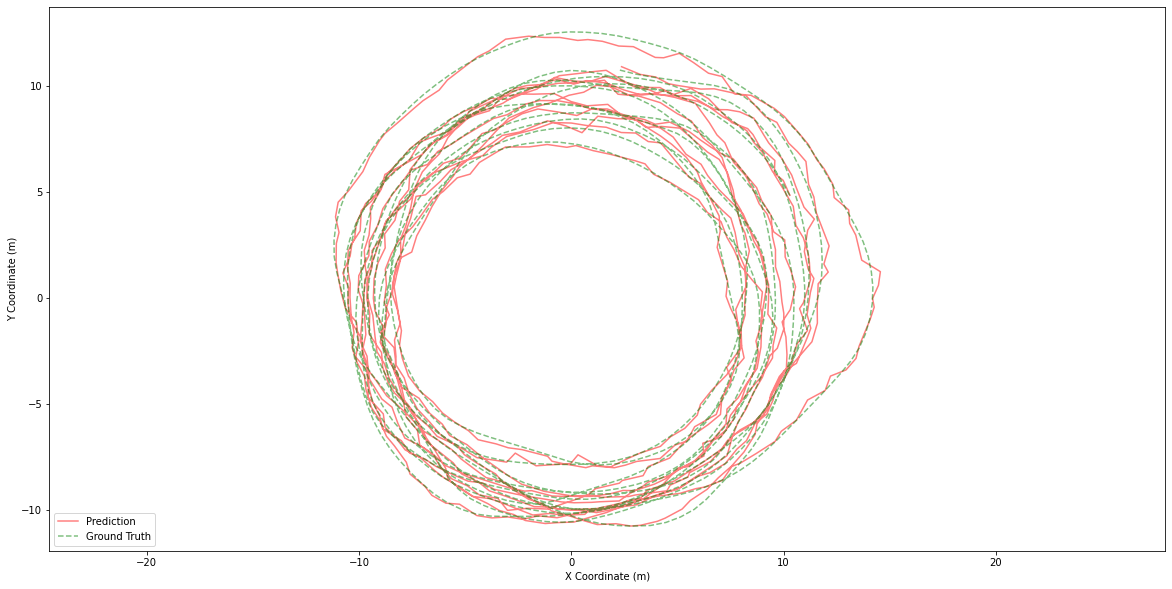

In [16]:
example = next(iter(full_datagen.train_ds))
model_plot2D(model, example, 0, df_mean=new_df.mean()[:3], df_std=new_df.std()[:3] + 1e-10) # [:3] is label columns x,y,z